In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *   #lit,col,expr,regexp_extract,regexp_replace,current_date, current_timestamp,date_format
from pyspark.sql.types import StructField,StringType,StructType,DoubleType,LongType,IntegerType,FloatType,TimestampType,DataType
import pyspark
import pandas as pd

In [3]:
spark= SparkSession.builder.appName("DataFrame").getOrCreate()

In [4]:
data_bank=spark.read.csv("BankChurners.csv",sep=",",inferSchema=True,header=True)

In [5]:
data_bank.cache()

DataFrame[CLIENTNUM: int, Attrition_Flag: string, Customer_Age: int, Gender: string, Dependent_count: int, Education_Level: string, Marital_Status: string, Income_Category: string, Card_Category: string, Months_on_book: int, Total_Relationship_Count: int, Months_Inactive_12_mon: int, Contacts_Count_12_mon: int, Credit_Limit: double, Total_Revolving_Bal: int, Avg_Open_To_Buy: double, Total_Amt_Chng_Q4_Q1: double, Total_Trans_Amt: int, Total_Trans_Ct: int, Total_Ct_Chng_Q4_Q1: double, Avg_Utilization_Ratio: double, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1: double, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2: double]

In [6]:
data_bank.createOrReplaceTempView("data_bank")

In [7]:
data_bank.show(5)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [8]:
# Consulta para valores nulos
valores_nulos=[spark.sql("SELECT count({0}) as {0} FROM data_bank where {0}==NULL".format(i)).show() for i in data_bank.columns]

+---------+
|CLIENTNUM|
+---------+
|        0|
+---------+

+--------------+
|Attrition_Flag|
+--------------+
|             0|
+--------------+

+------------+
|Customer_Age|
+------------+
|           0|
+------------+

+------+
|Gender|
+------+
|     0|
+------+

+---------------+
|Dependent_count|
+---------------+
|              0|
+---------------+

+---------------+
|Education_Level|
+---------------+
|              0|
+---------------+

+--------------+
|Marital_Status|
+--------------+
|             0|
+--------------+

+---------------+
|Income_Category|
+---------------+
|              0|
+---------------+

+-------------+
|Card_Category|
+-------------+
|            0|
+-------------+

+--------------+
|Months_on_book|
+--------------+
|             0|
+--------------+

+------------------------+
|Total_Relationship_Count|
+------------------------+
|                       0|
+------------------------+

+----------------------+
|Months_Inactive_12_mon|
+------------------

In [9]:
#spark.sql("ALTER TABLE data_bank DROP COLUMN CLIENTNUM")
data_bank=data_bank.drop(col('CLIENTNUM'),col('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'),col('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'))

In [10]:
#spark.sql("ALTER TABLE data_bank DROP COLUMN Customer_Age")

# reducion de caracteristicas y dimencionalidad

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
from pyspark.ml.feature import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [13]:
data_popularity=spark.read.csv("OnlineNewsPopularity.csv",inferSchema=True,sep=',',header=True)

In [14]:
data_popularity.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: do

In [15]:
#Eliminamos varibales que no son determinantes
data_bank=data_bank.drop(col("url"),col("timedelta"))   #Url y Timedelta

In [16]:
data_bank.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+--------

In [17]:
from pyspark.ml.feature import VectorAssembler

#Vector Assembler como entrada acepta discretos y continuos
inputcols=data_bank.drop('Credit_Limit','Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category',
'Card_Category','Credit_Limit').columns
outputcols='features'
asambler=VectorAssembler(inputCols=inputcols,outputCol=outputcols)

In [18]:
features=asambler.transform(data_bank)

In [19]:
features.createOrReplaceTempView('features')

In [20]:
features=spark.sql("""SELECT Credit_Limit as label,features 
                    FROM features""")

In [21]:
# Usamos la funcion de puntaje Chi-cuadrado int:categorica out:categorica
"""
selectionMode:"numTopFeatures"
selectionMode:"fpr" prueba p

"""
from pyspark.ml.feature import UnivariateFeatureSelector
selector=UnivariateFeatureSelector(featuresCol="features",outputCol="selectedFeatures",
                                    labelCol="label",selectionMode="fpr")

# int:continua out:continua utilizo el metodo de prueba t don valor p
selector.setFeatureType("continuous").setLabelType("continuous").setSelectionThreshold(0.05)

UnivariateFeatureSelector_23bd1a84861d

In [22]:
result=selector.fit(features)

In [23]:
result.transform(features).show(5,truncate=False)   #Valor p<0.05 son significativo caso contrario no lo son 


+-------+-----------------------------------------------------------------------+-------------------------------------------------+
|label  |features                                                               |selectedFeatures                                 |
+-------+-----------------------------------------------------------------------+-------------------------------------------------+
|12691.0|[45.0,3.0,39.0,5.0,1.0,3.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061]|[3.0,5.0,1.0,3.0,777.0,11914.0,1144.0,42.0,0.061]|
|8256.0 |[49.0,5.0,44.0,6.0,1.0,2.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105] |[5.0,6.0,1.0,2.0,864.0,7392.0,1291.0,33.0,0.105] |
|3418.0 |[51.0,3.0,36.0,4.0,1.0,0.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.0]     |[3.0,4.0,1.0,0.0,0.0,3418.0,1887.0,20.0,0.0]     |
|3313.0 |[40.0,4.0,34.0,3.0,4.0,1.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.76]  |[4.0,3.0,4.0,1.0,2517.0,796.0,1171.0,20.0,0.76]  |
|4716.0 |[40.0,3.0,21.0,5.0,1.0,0.0,0.0,4716.0,2.175,816.0,28.0,2.5,0.0]    

In [24]:
# Usamos la funcion de puntaje Chi-cuadrado int:categorica out:categorica
"""
selectionMode:"numTopFeatures"
selectionMode:"fpr" prueba p

"""
from pyspark.ml.feature import UnivariateFeatureSelector
selector=UnivariateFeatureSelector(featuresCol="features",outputCol="numTopFeatures",
                                    labelCol="label",selectionMode="numTopFeatures")

# int:continua out:continua utilizo el metodo de prueba t don valor p
selector.setFeatureType("continuous").setLabelType("continuous").setSelectionThreshold(5)

UnivariateFeatureSelector_de16c7badbdb

In [25]:
selector.fit(features).transform(features).show(5,truncate=False)

+-------+-----------------------------------------------------------------------+-------------------------------+
|label  |features                                                               |numTopFeatures                 |
+-------+-----------------------------------------------------------------------+-------------------------------+
|12691.0|[45.0,3.0,39.0,5.0,1.0,3.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061]|[5.0,11914.0,1144.0,42.0,0.061]|
|8256.0 |[49.0,5.0,44.0,6.0,1.0,2.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105] |[6.0,7392.0,1291.0,33.0,0.105] |
|3418.0 |[51.0,3.0,36.0,4.0,1.0,0.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.0]     |[4.0,3418.0,1887.0,20.0,0.0]   |
|3313.0 |[40.0,4.0,34.0,3.0,4.0,1.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.76]  |[3.0,796.0,1171.0,20.0,0.76]   |
|4716.0 |[40.0,3.0,21.0,5.0,1.0,0.0,0.0,4716.0,2.175,816.0,28.0,2.5,0.0]        |[5.0,4716.0,816.0,28.0,0.0]    |
+-------+-----------------------------------------------------------------------+-------

# Normalizar valores de columnas

In [26]:
from pyspark.ml.feature import MinMaxScaler
input="features"
outpot="std_features"
minmaxscaler=MinMaxScaler(min=0,max=1,inputCol=input,outputCol=outpot)
result=minmaxscaler.fit(features).transform(features)

In [27]:
result.show(5,truncate=False)

+-------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label  |features                                                               |std_features                                                                                                                                                                                                                       |
+-------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|12691.0|[45.0,3.0,39.0,5.0,1.0,3.0,777.0,11914.0,1.335,1144.0,42.0,1.

In [28]:
from pyspark.ml.feature import VarianceThresholdSelector
input="std_features"
output="selectrdFeatures"

varianceselector=VarianceThresholdSelector(featuresCol=input,outputCol=output,varianceThreshold=0.01)


In [29]:
varianceselector.fit(result).transform(result).show(5,truncate=False)

+-------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label  |features                                                               |std_features                                                                                                                                                                                                                       |selectrdFeatures                                                                                                                                                                           |
+---

In [30]:
from pyspark.ml.feature import PCA

input="std_features"
output="selectrdFeatures"

PCAselector=PCA(inputCol=input,outputCol=output,k=3)


In [31]:
Final=PCAselector.fit(result)

In [32]:
Final.transform(result)

DataFrame[label: double, features: vector, std_features: vector, selectrdFeatures: vector]

In [33]:
dic={}
for i in inputcols:
    dic[i]=data_bank.stat.corr('Credit_Limit',i)    #Credit_Limit

In [34]:
dic

{'Customer_Age': 0.0024762273596646957,
 'Dependent_count': 0.06806460020347015,
 'Months_on_book': 0.007507009229698235,
 'Total_Relationship_Count': -0.07138581742352745,
 'Months_Inactive_12_mon': -0.020393791443455035,
 'Contacts_Count_12_mon': 0.02081701171626794,
 'Total_Revolving_Bal': 0.04249260734895825,
 'Avg_Open_To_Buy': 0.995980543932001,
 'Total_Amt_Chng_Q4_Q1': 0.012812535653393454,
 'Total_Trans_Amt': 0.17173015046794077,
 'Total_Trans_Ct': 0.07592691199468905,
 'Total_Ct_Chng_Q4_Q1': -0.0020198499941714303,
 'Avg_Utilization_Ratio': -0.4829650714174503}

In [35]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [36]:
corr=data_bank[[inputcols]].toPandas().corr()

<AxesSubplot:>

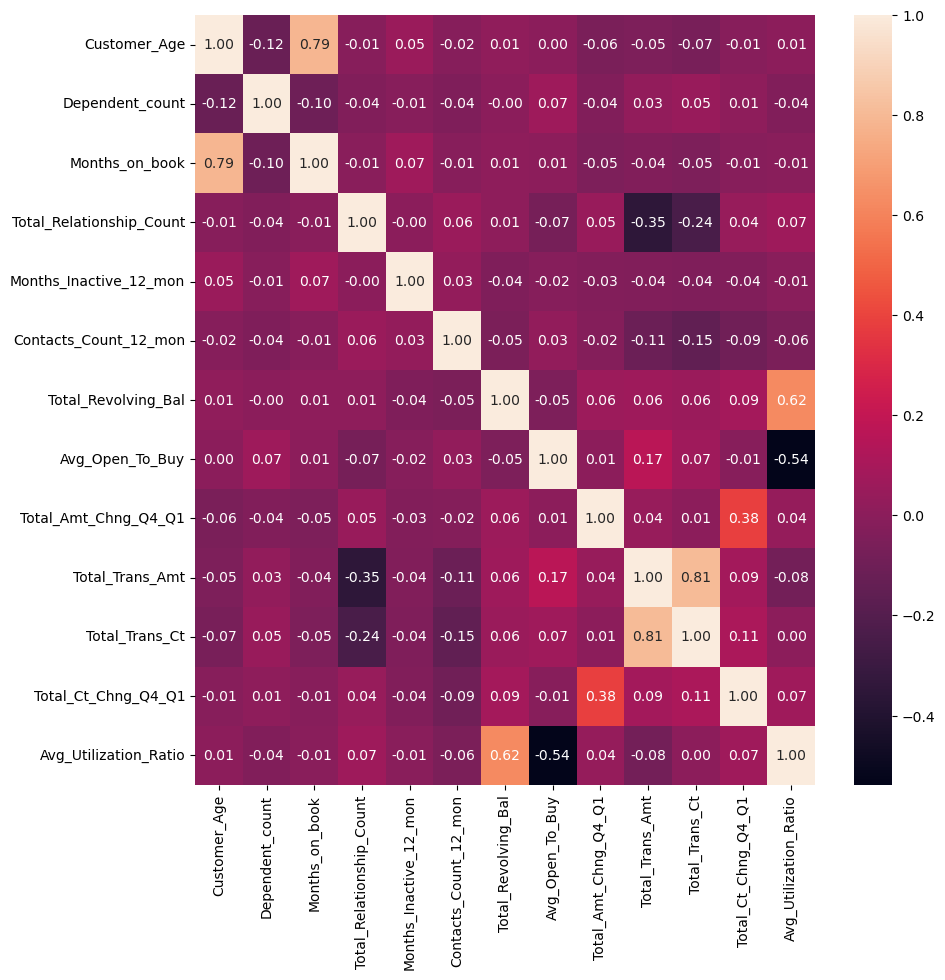

In [37]:
fig,axes=plt.subplots(figsize=(10,10))

sb.heatmap(corr,annot=True,fmt='.2f')

In [48]:
# Define los porcentajes de partición
p1 = 0.6  # 60%
p2 = 0.2  # 20%

# Divide el DataFrame en tres DataFrames más pequeños utilizando el método sample
data_train = features.sample(False, p1)
data_test = features.sample(False, p2)

In [61]:
from pyspark.ml.regression import LinearRegression
LR=LinearRegression(featuresCol="features",labelCol="label",maxIter=10,regParam=0.3,elasticNetParam=0.8)

In [62]:
modelRL=LR.fit(data_train)

In [63]:
modelRL.coefficients,modelRL.intercept

(DenseVector([1.3876, -1.3324, -1.5255, -4.8149, 0.0474, 3.1874, 1.0125, 0.9999, 0.0, -0.0146, 1.999, 3.2825, -26.1097]),
 -70.37652432633645)

In [67]:
modelRL.summary.rootMeanSquaredError,modelRL.summary.r2

(30.19055180478633, 0.9999890908803968)

In [69]:
prediccion=modelRL.transform(data_test)
prediccion.show()

+-------+--------------------+------------------+
|  label|            features|        prediction|
+-------+--------------------+------------------+
|11751.0|[56.0,1.0,36.0,3....| 11709.34796606315|
| 4234.0|[44.0,4.0,37.0,5....|  4191.03260509538|
|13535.0|[41.0,3.0,34.0,4....|13494.967438798125|
|10100.0|[44.0,3.0,34.0,5....|10042.351431862966|
| 2650.0|[53.0,2.0,38.0,5....|2620.6073895333084|
|12555.0|[58.0,0.0,49.0,6....|12516.393962525572|
|15433.0|[42.0,4.0,36.0,2....|15393.590888970542|
|17304.0|[50.0,1.0,43.0,3....|17302.295361613487|
| 2802.0|[49.0,3.0,36.0,2....|2801.6508483137345|
|34516.0|[51.0,4.0,42.0,3....|34523.681480063795|
| 2910.0|[54.0,1.0,43.0,4....| 2870.037072868449|
|24312.0|[44.0,1.0,35.0,3....| 24296.20035363903|
|34516.0|[44.0,1.0,36.0,6....| 34480.29578532219|
| 2158.0|[55.0,4.0,45.0,2....| 2107.291524238989|
| 6576.0|[45.0,1.0,36.0,4....| 6550.476045999719|
| 2940.0|[53.0,3.0,34.0,6....|2918.5432663064626|
| 1862.0|[44.0,3.0,25.0,3....|1848.7461033223487|


In [83]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(predictionCol="prediction",labelCol="label",metricName="rmse")
evaluator.evaluate(prediccion)

29.81689068859307

# Arboles de desciones

In [82]:
from pyspark.ml.regression import DecisionTreeRegressor

dt=DecisionTreeRegressor(featuresCol="features",labelCol="label")
dt_model=dt.fit(data_train)
dt_prediccion=dt_model.transform(data_test)
dt_evaluater=RegressionEvaluator(labelCol="label",predictionCol="prediction",metricName="rmse")
dt_evaluater.evaluate(dt_prediccion)

691.0733219203628

In [80]:
dt_prediccion.show()

+-------+--------------------+------------------+
|  label|            features|        prediction|
+-------+--------------------+------------------+
|11751.0|[56.0,1.0,36.0,3....|13468.195767195768|
| 4234.0|[44.0,4.0,37.0,5....| 5152.813725490196|
|13535.0|[41.0,3.0,34.0,4....|13468.195767195768|
|10100.0|[44.0,3.0,34.0,5....|11803.989417989418|
| 2650.0|[53.0,2.0,38.0,5....|2637.8648915187377|
|12555.0|[58.0,0.0,49.0,6....|11803.989417989418|
|15433.0|[42.0,4.0,36.0,2....|14840.883720930233|
|17304.0|[50.0,1.0,43.0,3....|16295.509615384615|
| 2802.0|[49.0,3.0,36.0,2....|2637.8648915187377|
|34516.0|[51.0,4.0,42.0,3....| 34273.34640522876|
| 2910.0|[54.0,1.0,43.0,4....|2637.8648915187377|
|24312.0|[44.0,1.0,35.0,3....| 22635.33870967742|
|34516.0|[44.0,1.0,36.0,6....| 34273.34640522876|
| 2158.0|[55.0,4.0,45.0,2....|2712.1186440677966|
| 6576.0|[45.0,1.0,36.0,4....| 6919.805882352941|
| 2940.0|[53.0,3.0,34.0,6....|  1793.21740812379|
| 1862.0|[44.0,3.0,25.0,3....|  1793.21740812379|
